### When a photograph of a square is taken from a tilted angle, and on further perspective transform, one usually observes that a trapezium gets converted to a rectange (or a square in some cases).

### An accurate algorithm tries to retain the aspect ratio of the original square as much as possible, unless in certain circumstances owing to the angle of the image, it is very hard to retain the aspect ratio.

### In this notebook, two different algorithms which demonstrate the difference in the aspect ratio of the perspective-transformed images from the actual image, along with the extent of the deviation is presented. The algorithms are compared with the performance of warping which is done by a Cam Scanner

## For the sake of illustration, a 10 cm * 10 cm square is drawn on a graph sheet (so the actual aspect ratio is 1.00). The aspect ratios of the warped images is assessed for their deviation from 1.00

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import path
import cv2

import os

import matplotlib.pyplot as plt
import numpy as np

import mpld3
from mpld3 import plugins




from skimage import io
from skimage import transform
#from skimage import segmentation
from skimage import filters
#from skimage import morphology
from skimage import measure
from skimage import util

from sklearn import cluster

from scipy.spatial import ConvexHull

In [2]:
class ImageDetection:
    
    def __init__(self,imgFile,farmWidth=3.0):
        self.imgFile = imgFile
        self.farmWidth = farmWidth
        
    def read(self,invert=False):
        img = io.imread(self.imgFile,as_gray=True)
        img = util.img_as_float(img)
        if invert:
            img = util.invert(img)    
        self.img = img
        self.img_x, self.img_y = img.shape
        return img
    
    def readRGB(self):
        self.rgbimg = io.imread(self.imgFile)
        return self.rgbimg
        
    def rescale(self,img,scale):
        if self.img is not None:
            self.scale = np.float(scale)
            self.img_rs = transform.rescale(self.img,self.scale,multichannel=False)
            return self.img_rs
            
    def plotImg(self,img,title=None,cmap='gray',figsize=(15,15)):
        fig, ax = plt.subplots(1,1,figsize=figsize)
        #ax.axis('off')
        ax.imshow(img,cmap=cmap)
        if title:
            ax.set_title(title,fontsize=20)
        plt.show()

    def plotHist(self,img,title=None):
        fig, ax = plt.subplots(1, 1)
        ax.hist(img.ravel(), bins=32, range=[0.0, 1.2])
        ax.set_xlim(0.0,1.2);
        if title:
            ax.set_title(title,fontsize=20)
        plt.show()
        
    def plotCoords(self,coords,s=1,c='r',fmt='ro'):
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        ax.plot(coords[:,0],coords[:,1],fmt)
        plt.show()        
        
    def gaussFilter(self,img,sigma=1):
        return filters.gaussian(img,sigma)
    
    def getLocalThresh(self,img, block_size=101, offset=-0.05):
        return filters.threshold_local(img,block_size=block_size, offset=offset) 
    
    def binarizeThresh(self,img,thresh):
        return img>thresh
    
    def blurThicken(self,img,sigma=1):
        img_blur = self.gaussFilter(img,sigma)
        return self.binarizeThresh(img_blur,0)
    
    def applyBinMask(self,img,binMask):
        return np.multiply(img,binMask)
    
    def getThickBinMask(self,img,initSigma=1,block_size=101,offset=-0.05,finalSigma=1):
        img_gauss = self.gaussFilter(img,sigma=initSigma)
        img_thresh = self.getLocalThresh(img_gauss,block_size=block_size,offset=offset)
        img_bin = self.binarizeThresh(img_gauss,img_thresh)
        img_bin_thick = imgD.blurThicken(img_bin,sigma=finalSigma)
        return img_bin_thick
    
    def getCoords_Img(self,img):
        numRow, numCol = img.shape
        ygrid, xgrid = np.mgrid[:numRow, :numCol]
        coords = np.vstack((xgrid.ravel(), ygrid.ravel())).T
        return coords
    
    def getCoords_binImg(self,img):
        a = np.ones(img.shape)
        x_i = np.linspace(0,img.shape[0]-1,img.shape[0]).astype('uint')
        y_i = np.linspace(0,img.shape[1]-1,img.shape[1]).astype('uint')
        x_mask = np.multiply(a.T,x_i).T
        y_mask = np.multiply(a,y_i)
        x_coords = np.multiply(a,x_mask)
        y_coords = np.multiply(a,y_mask)
        all_coords = np.vstack((x_coords.flatten(),y_coords.flatten())).T.astype('uint')
        res = all_coords[img.flatten().astype('uint8')==1]
        return res
    
    def applyDBSCAN(self,coords,eps=10, min_samples=30):
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(coords)
        predictions = dbscan.labels_
        return predictions
    
    def getGroupNums(self,groups,include0=True):
        if include0:
            return np.unique(groups)
        else:
            all_groups = np.unique(groups)
            index = np.where(all_groups == 1)
            return all_groups[index[0][0]:]
    
    def applyLabels_binImg(self,img,coords,labels):
        label_mask = np.zeros(img.shape).astype('uint')
        for i in range(len(coords)):
            row,col = coords[i]
            label_mask[row][col]=labels[i]
        return label_mask
    
    def upscale_binMask(self,img,rs_mask,scale):
        rs_mask_upscale = transform.rescale(rs_mask,1.0/scale,multichannel=False)
        full_mask = np.zeros(img.shape)
        full_mask[:rs_mask_upscale.shape[0],:rs_mask_upscale.shape[1]] = rs_mask_upscale
        return full_mask
    
    def applyConvexHull_Groups(self,coords,groups):
        groupNums = np.unique(groups)

        groupCoords = []
        groupHulls = []
        #img_rs_groups = []
        groupVertices = []

        for groupNum in groupNums:
            thisCoords = []
            for i in range(len(coords)):
                if groups[i]==groupNum:
                    thisCoords.append(coords[i])
            groupCoords.append(np.array(thisCoords))
            thisHull = ConvexHull(thisCoords)
            groupHulls.append(thisHull)
            #thisImg = np.multiply(img, img_groups==groupNum)
            #img_rs_groups.append(thisImg)
            thisVertices = []
            for vertex in thisHull.vertices:
                thisVertices.append([thisCoords[vertex][1],thisCoords[vertex][0]])
            groupVertices.append(np.array(thisVertices))
            
        return groupCoords,groupHulls,groupVertices
    
    def getImg_GroupMask(self,img,img_groups,groupNum):
        return np.multiply(img, img_groups==groupNum)    
    
    def plotRGBImg_GroupsRS(self,rgbimg,groups,groupNums,groupVertices,scale,
                            fmt='k-',linewidth=1,annotate=True):
        fig, ax = plt.subplots(1,1,figsize=(15, 15))
        ax.axis('off')
        ax.imshow(rgbimg)
        for groupNum in groupNums:
            ax.fill(groupVertices[groupNum][:,0]/scale,
                    groupVertices[groupNum][:,1]/scale,
                    fmt,linewidth=linewidth,fill=False)
            if annotate:
                ax.annotate(groupNum,xy=(groupVertices[groupNum][0][0]/scale,
                                         groupVertices[groupNum][0][1]/scale))
        plt.show()        
         
    def plotRGBImg_var(self,rgbimg,groups,groupNums,groupVertices,scale, fmt='k-',linewidth=1,annotate=True):
        fig, ax = plt.subplots(1,1,figsize=(15, 15))
        ax.axis('off')
        ax.imshow(rgbimg)
        for groupNum in groupNums:
            if annotate:
                ax.annotate(groupNum,xy=(groupVertices[groupNum][0][0]/scale,
                                         groupVertices[groupNum][0][1]/scale))
        plt.show()        
                 
            
            
    def getGroupDetails(self,img,
                        initSigma=1,block_size=101,offset=-0.05,finalSigma=1,
                        eps=10,min_samples=30):
        img_bin_thick = self.getThickBinMask(img,initSigma=initSigma,
                                             block_size=block_size,
                                             offset=offset,
                                             finalSigma=finalSigma)
        coords = self.getCoords_binImg(img_bin_thick)
        groups = self.applyDBSCAN(coords,
                                  eps=eps,
                                  min_samples=min_samples)
        groupCoords,groupHulls,groupVertices = self.applyConvexHull_Groups(coords,groups)
        groupLabel_Mask = self.applyLabels_binImg(img,coords,groups)
        return groups,groupCoords,groupHulls,groupVertices,groupLabel_Mask

    
    def getMaskSubImg(self,img,scale,groupVertices,groupNum):
        scaledVertices = np.array(groupVertices[groupNum])/scale
        groupPath = path.Path(scaledVertices,closed=False)
        coords = self.getCoords_Img(img)
        mask = groupPath.contains_points(coords)
        mask = mask.reshape(img.shape)
        return mask
        
    
    def getSubImg(self,img,scale,groupVertices,groupNum,applyMask=True):
        min_x = int(np.min(groupVertices[groupNum][:,0])/scale)
        max_x = int(np.max(groupVertices[groupNum][:,0])/scale)
        min_y = int(np.min(groupVertices[groupNum][:,1])/scale)
        max_y = int(np.max(groupVertices[groupNum][:,1])/scale)
        if applyMask:
            mask = self.getMaskSubImg(img,scale,groupVertices,groupNum)
            masked_img = self.applyBinMask(img,mask)
            subimg = masked_img[min_y:max_y,min_x:max_x]
        else:
            subimg = img[min_y:max_y,min_x:max_x]
        return subimg
    
    def fitLine_imgBin(self,img,coords,plot=True):
        if len(coords)==0:
            return 0,0
        
        model = measure.LineModelND()
        model.estimate(coords)

        line_x = np.arange(0, img.shape[0])
        line_y = model.predict_y(line_x)

        coeff = (line_y[-1]-line_y[0])/(line_x[-1]-line_x[0])
        intercept = model.predict_y([0])
        
        if plot:
            fig, ax = plt.subplots(1,1,figsize=(10,10))
            ax.plot(coords[:,0],coords[:,1],'ko')
            ax.plot(line_x,line_y,'r-',linewidth=4)
            plt.show()        
        
        return coeff,intercept
    
    def rotateImg(self,img,coeff):
        return transform.rotate(img,-np.degrees(np.arctan(coeff)),resize=True)
    
    def rotateSubImg(self,img,
                     plotFit=True,
                    initSigma=1,block_size=101,offset=-0.05,finalSigma=1):
        img_bin_thick = self.getThickBinMask(img,
                                             initSigma=initSigma,
                                             block_size=block_size,
                                             offset=offset,
                                             finalSigma=finalSigma)
        img_coords = self.getCoords_binImg(img_bin_thick)
        coeff,intercept = self.fitLine_imgBin(img_bin_thick,img_coords,plot=plotFit)
        return self.rotateImg(img,coeff)
        
        
    
    def cropMask(self,img,mask):
        x_i = np.argmax(mask,axis=0)
        x_inz = np.nonzero(x_i)
        y_i = np.argmax(mask,axis=1)
        y_inz = np.nonzero(y_i)
        if ((len(x_inz[0])==0 or len(y_inz[0])==0)):
            return np.array([[0]])
        min_x = x_inz[0][0]
        max_x = x_inz[0][-1]
        img_w = mask.shape[1]
        min_y = y_inz[0][0]
        max_y = y_inz[0][-1]
        img_h = mask.shape[0]
        crops = ((min_y,img_h-max_y-1),(min_x,img_w-max_x-1))
        return util.crop(img,crops)
    
    def cropSubImg(self,img,sigma=3,thresh=0.7):
        img_gauss = self.gaussFilter(img,sigma=sigma)
        img_bin = self.binarizeThresh(img_gauss,thresh=thresh)
        return self.cropMask(img,img_bin)   
    
    def getAspectRatio(self,img):
        aspectRatio = np.float(img.shape[0]/img.shape[1])
        if aspectRatio == 0:
            aspectRatio = 1
        return aspectRatio
    
    def getAreaRatio(self,img,
                     initSigma=1,block_size=101,offset=-0.05,finalSigma=1):
        img_bin_thick = self.getThickBinMask(img,
                                    initSigma=initSigma,
                                    block_size=block_size,
                                    offset=offset,
                                    finalSigma=finalSigma)
        actualArea = np.sum(img_bin_thick)
        imgArea = img.shape[0]*img.shape[1]
        return np.float(actualArea/imgArea)
    
    def getSizeRatio(self,img,subimg):
        img_x, img_y = img.shape
        subimg_x, subimg_y = subimg.shape
        return (subimg_x*subimg_y)/(img_x*img_y)
    
    def check_img_is_farm(self,img):
        sizeRatio = self.getSizeRatio(self.img,img)
        isNormalSize = sizeRatio > 0.001 and sizeRatio < 0.025
        aspectRatio = self.getAspectRatio(img)
        isRect = aspectRatio>2.5 or aspectRatio<1.0/2.5
        isFarm = isNormalSize and isRect
        return isFarm
    
    def check_farm_is_full(self,img):
        if self.check_img_is_farm(img):
            return self.getAreaRatio(img)>0.5
        return False
    
    def get_farm_length(self,img):
        if self.check_img_is_farm(img):
            aspectRatio = self.getAspectRatio(img)
            if aspectRatio>1:
                farmLength = self.farmWidth*aspectRatio
            else:
                farmLength = self.farmWidth/aspectRatio
            return farmLength
        return 0.0
    
    def get_farm_area(self,img):
        if self.check_img_is_farm(img):
            return self.farmWidth*self.get_farm_length(img)
        return 0.0
    
    def determineOptimumThresh_Crop(self,img,sigma=3):
        a = np.linspace(0.0,100,21)
        b = ((-1)**(a%2))*a/4
        thresholds = 0.75+b/100
        threshs = []
        metric = []
        #thresholds = np.linspace(0.5,1.0,20)
        for thresh in thresholds:
            threshs.append(thresh)
            subimg = self.cropSubImg(img,sigma=sigma,thresh=thresh)
            areaRatio = self.getAreaRatio(subimg)
            metric.append(subimg.shape[0]*subimg.shape[1]*areaRatio)
        optThresh = threshs[np.argmax(metric)]
        return optThresh
        

    

In [3]:
#NOTE - FROM HERE - THE ADDITIONAL CODES COMPLIED BY PRANEETH - BEGIN
#LOT OF FUNCTIONS ARE IMPORTED READILY FROM EXISTING CODE

def minimum_bounding_rectangle(temp):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    
    import numpy as np
    from scipy.spatial import ConvexHull

    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    #hull_points = points[ConvexHull(points).vertices]
    
    hull_points = temp
    
    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    rval2 = np.array(rval, np.int32)
    return(rval2)



def polygon_area(x1,y1):
    
    #computes the area of a polygon given the coordinates of the polygon
    
    # coordinate shift
    x = np.array(x1)
    y = np.array(y1)
    x_ = x - x.mean()
    y_ = y - y.mean()
    # everything else is the same as maxb's code
    correction = x_[-1] * y_[0] - y_[-1]* x_[0]
    main_area = np.dot(x_[:-1], y_[1:]) - np.dot(y_[:-1], x_[1:])
    return 0.5*np.abs(main_area + correction)




def max_index_compute(temp):
    #given an input of convex hull points - this function outputs the collection of 4 points
    #which are the set of points of the quadrilateral - which are the best representative
    #of a large cluster of points
        
        
    cvX = temp[:,0]
    cvY = temp[:,1]

    numberOfPoints = len(cvX)
    maxArea = 0;
    
    for k1 in range(numberOfPoints):
      for k2 in range(numberOfPoints):
        for k3 in range(numberOfPoints):
          for k4 in range(numberOfPoints):
                    verticesX = [cvX[k1], cvX[k2], cvX[k3], cvX[k4]]
                    verticesY = [cvY[k1], cvY[k2], cvY[k3], cvY[k4]]
                    #thisArea = PolyArea(verticesX, verticesY)
                    thisArea = polygon_area(verticesX, verticesY)
                    if thisArea > maxArea:
                      maxArea = thisArea
                      indexesAtmax = [k1, k2, k3, k4]
    
    op = temp[indexesAtmax]
    return(op)



def order_points(pts):
    
    #given an input of four points, this function returns the points ordered in a clockwise
    #manner
    
    from scipy.spatial import distance as dist
    import numpy as np
    import cv2
    import scipy
    
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")



def asp_ratio(img, ordered_points_int, center_coordinates):
    
    #This function is adapted from 
    #https://www.microsoft.com/en-us/research/publication/whiteboard-scanning-image-enhancement/?from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fum%2Fpeople%2Fzhang%2Fpapers%2Ftr03-39.pdf
    #assuming a pinhole camera model, it is possible to calculate the aspect ratio for a projected rectangle (but not the scale, unsurprisingly). Essentially, one can solve for the focal length, then get the aspect ratio
    
    #the problem with this method is 1/0 error in focal length occurs at times causing blowing up
    #moreover the aspect ratios which are output are quite varied
    #the pinhole model does not work for this case.
    
    import math
    import scipy
    from scipy.spatial import distance as dist
    import numpy as np
    import cv2

    coordA = ordered_points_int[0]
    coordB = ordered_points_int[1]
    coordC= ordered_points_int[3]
    coordD= ordered_points_int[2]
    
    p = (coordA, coordB, coordC, coordD)
    
    v0 = center_coordinates[1]
    u0 = center_coordinates[0]
    
    
    #detected corners on the original image
    
    #widths and heights of the projected image
    w1 = scipy.spatial.distance.euclidean(p[0],p[1])
    w2 = scipy.spatial.distance.euclidean(p[2],p[3])
    
    h1 = scipy.spatial.distance.euclidean(p[0],p[2])
    h2 = scipy.spatial.distance.euclidean(p[1],p[3])
    
    w = max(w1,w2)
    h = max(h1,h2)
    
    #visible aspect ratio
    ar_vis = float(w)/float(h)
    
    #make numpy arrays and append 1 for linear algebra
    m1 = np.array((p[0][0],p[0][1],1)).astype('float32')
    m2 = np.array((p[1][0],p[1][1],1)).astype('float32')
    m3 = np.array((p[2][0],p[2][1],1)).astype('float32')
    m4 = np.array((p[3][0],p[3][1],1)).astype('float32')
    
    #calculate the focal disrance
    k2 = np.dot(np.cross(m1,m4),m3) / np.dot(np.cross(m2,m4),m3)
    k3 = np.dot(np.cross(m1,m4),m2) / np.dot(np.cross(m3,m4),m2)
    
    n2 = k2 * m2 - m1
    n3 = k3 * m3 - m1
    
    n21 = n2[0]
    n22 = n2[1]
    n23 = n2[2]
    
    n31 = n3[0]
    n32 = n3[1]
    n33 = n3[2]
    
    f = math.sqrt(np.abs( (1.0/(n23*n33)) * ((n21*n31 - (n21*n33 + n23*n31)*u0 + n23*n33*u0*u0) + (n22*n32 - (n22*n33+n23*n32)*v0 + n23*n33*v0*v0))))
    
    A = np.array([[f,0,u0],[0,f,v0],[0,0,1]]).astype('float32')
    
    At = np.transpose(A)
    Ati = np.linalg.inv(At)
    Ai = np.linalg.inv(A)
    
    #calculate the real aspect ratio
    ar_real = math.sqrt(np.dot(np.dot(np.dot(n2,Ati),Ai),n2)/np.dot(np.dot(np.dot(n3,Ati),Ai),n3))
    
    if ar_real < ar_vis:
        try:
            W = int(w)
            H = int(W / ar_real)
        except:
            H = 1
    else:
        H = int(h)
        W = int(ar_real * H)
    
    pts1 = np.array(p).astype('float32')
    pts2 = np.float32([[0,0],[W,0],[0,H],[W,H]])
    
    #project the image with the new w/h
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(img,M,(W,H))
    #plt.imshow(dst)
    
    #cv2.imwrite('orig.png',img)
    #cv2.imwrite('proj.png',dst)
    
    return(ar_real,dst)

def asp_ratio_simpler(img, ordered_points_int):

    #this is a straightforward method to apply warping - not much of brain is used as far as the aspect ratio is concerned
    #aspect ratio is not accurately computed
    
    
    import math
    import scipy
    from scipy.spatial import distance as dist
    import numpy as np
    import cv2

    (tl, tr, br, bl) = ordered_points_int
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # ...and now for the height of our new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # construct our destination points which will be used to
      
    orig_new = np.array([ordered_points_int[0], ordered_points_int[1], ordered_points_int[3], ordered_points_int[2]],dtype = "float32" )
    dst_new = np.array([	[0, 0], [maxWidth - 1, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(orig_new, dst_new)
        
    warp = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    as_ratio = maxWidth/maxHeight
    
    return(as_ratio, warp)
    
 



In [4]:
def plotImg_trial(img,title=None,cmap='gray',figsize=(10,10)):
    
        fig, ax = plt.subplots(1,1,figsize=figsize)
        #ax.axis('off')
        ax.imshow(img,cmap=cmap)
        if title:
            ax.set_title(title,fontsize=20)
        plugins.connect(fig, plugins.MousePosition(fontsize=14))

        mpld3.show()

In [5]:
#imgFile = '/Users/praneeth/Downloads/Image Processing/Updates_in_Sep2020/images_from_video/DRONE_TRANSECT_AR_16SEP19 16.png'

imgFile = '/Users/praneeth/Desktop/Image_Warping/Original/im05.jpeg'
farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters

imgD = ImageDetection(imgFile,farmWidth)
img = imgD.read(invert=False)
imgrgb = imgD.readRGB()
imgrgb.shape



(1280, 960, 3)


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [02/Jun/2023 17:27:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 17:27:30] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Jun/2023 17:27:30] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


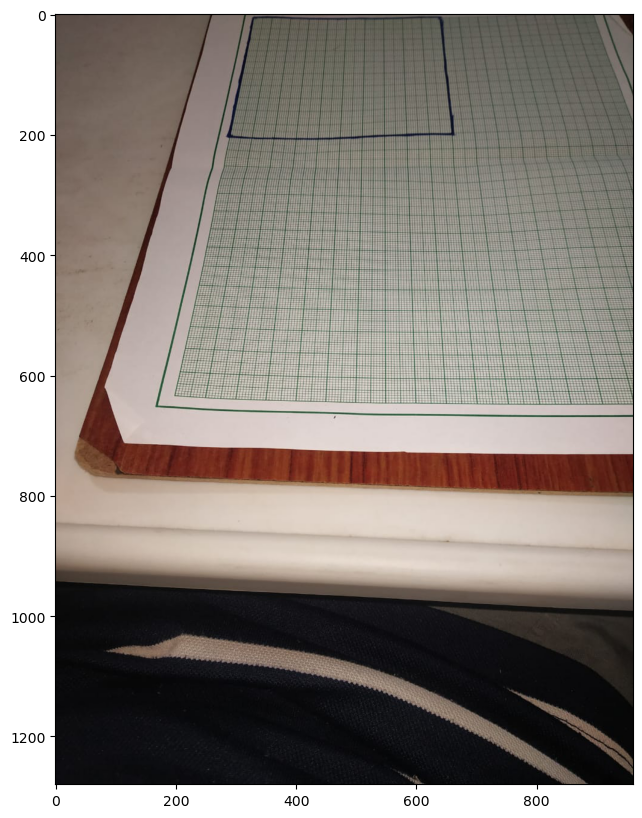

In [6]:
plotImg_trial(imgrgb)

### The following image shows a graph sheet with a square drawn on it which is a photographed from a tilted angle

/var/folders/fc/mjdjhyc14l1fg9j0fbzhj0_00000gn/T/ipykernel_28719/3416806670.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.scale = np.float(scale)
/var/folders/fc/mjdjhyc14l1fg9j0fbzhj0_00000gn/T/ipykernel_28719/3416806670.py:23: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  self.img_rs = transform.rescale(self.img,self.scale,multichannel=False)


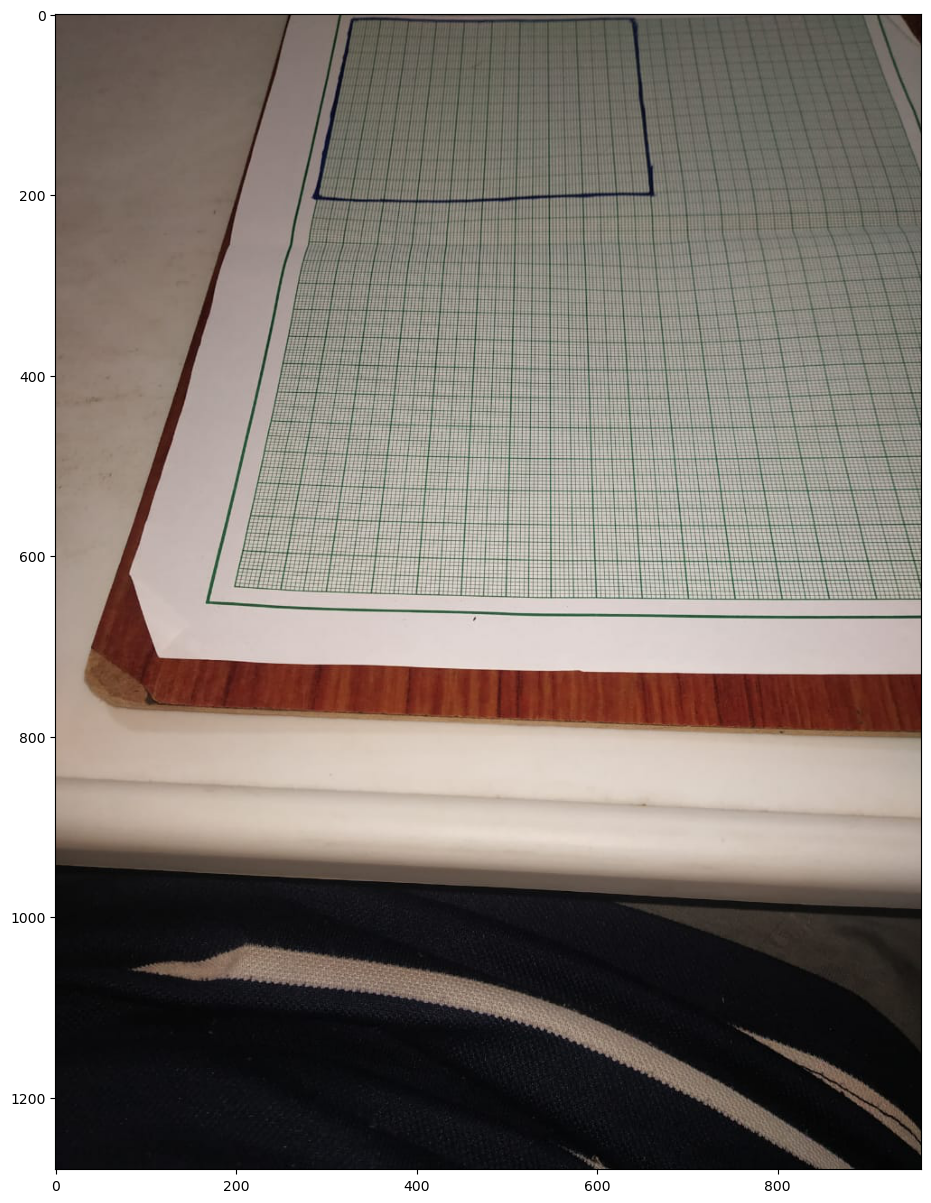

In [7]:
farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters

imgD = ImageDetection(imgFile,farmWidth)
img = imgD.read(invert=False)
imgrgb = imgD.readRGB()
scale = 1.0/4.0
img_rs = imgD.rescale(img,scale)
imgD.plotImg(imgrgb)

A similar procedure is adopted for 21 photographs taken from different angles

In [8]:
q1 = np.array([[58,291], [863, 267], [894,1100],[65,1100]], np.int32)

q2 = np.array([[152, 281], [753, 262], [788,900], [133, 898]], np.int32)

q3 = np.array([[218, 36], [743, 25], [769, 533], [190, 535]], np.int32)

q4 = np.array([[292, 56], [629, 48], [657, 286], [247, 291]], np.int32)

q5 = np.array([[324,5], [637,3], [656,198], [283,200]], np.int32)

q6 = np.array([[228, 790], [395, 790], [391, 971], [216, 973]], np.int32)

q7 = np.array([[303, 276], [505, 281], [501, 469], [289,458]], np.int32)

q8 = np.array([[367, 28], [482, 28], [480,134], [364,136]], np.int32)

q9 = np.array([[201, 195 ], [1130, 181     ], [ 1130, 1080     ],[222,1090     ]], np.int32)
q10 = np.array([[120, 621    ], [747, 633      ], [ 730, 1290    ],[111,1265     ]], np.int32)
q11 = np.array([[112, 108    ], [756, 141      ], [ 738, 815     ],[46, 782     ]], np.int32)
q12 = np.array([[265, 261    ], [549, 274      ], [542, 564      ],[246, 541     ]], np.int32)

q13 = np.array([[209, 234    ], [453, 240      ], [457, 493      ],[209, 487     ]], np.int32)
q14 = np.array([[292, 361    ], [648, 377      ], [654, 760    ],[292, 737    ]], np.int32)
q15 = np.array([[444, 511    ], [970, 515      ], [975, 1020    ],[434, 1020 ]], np.int32)
q16 = np.array([[195, 212    ], [1220, 228     ], [1180, 1280   ],[120, 1240    ]], np.int32)

q17 = np.array([[696, 181   ], [ 1605, 194   ], [ 1590, 1100  ],[679, 1070   ]], np.int32)
q18 = np.array([[510, 139   ], [ 1380, 177   ], [ 1510, 1150  ],[548, 1040   ]], np.int32)
q19 = np.array([[586, 176   ], [ 1460, 163   ], [ 1590, 1080  ],[660, 1030   ]], np.int32)
q20 = np.array([[912, 1030   ], [1880, 1130    ], [1630, 2060   ],[749, 2050   ]], np.int32)
q21 = np.array([[612, 562   ], [1370, 504    ], [1260, 1300  ],[455, 1370   ]], np.int32)


q = [q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, q15, q16, q17, q18, q19, q20, q21]

In [9]:

quadrangle_vertices = q[4]




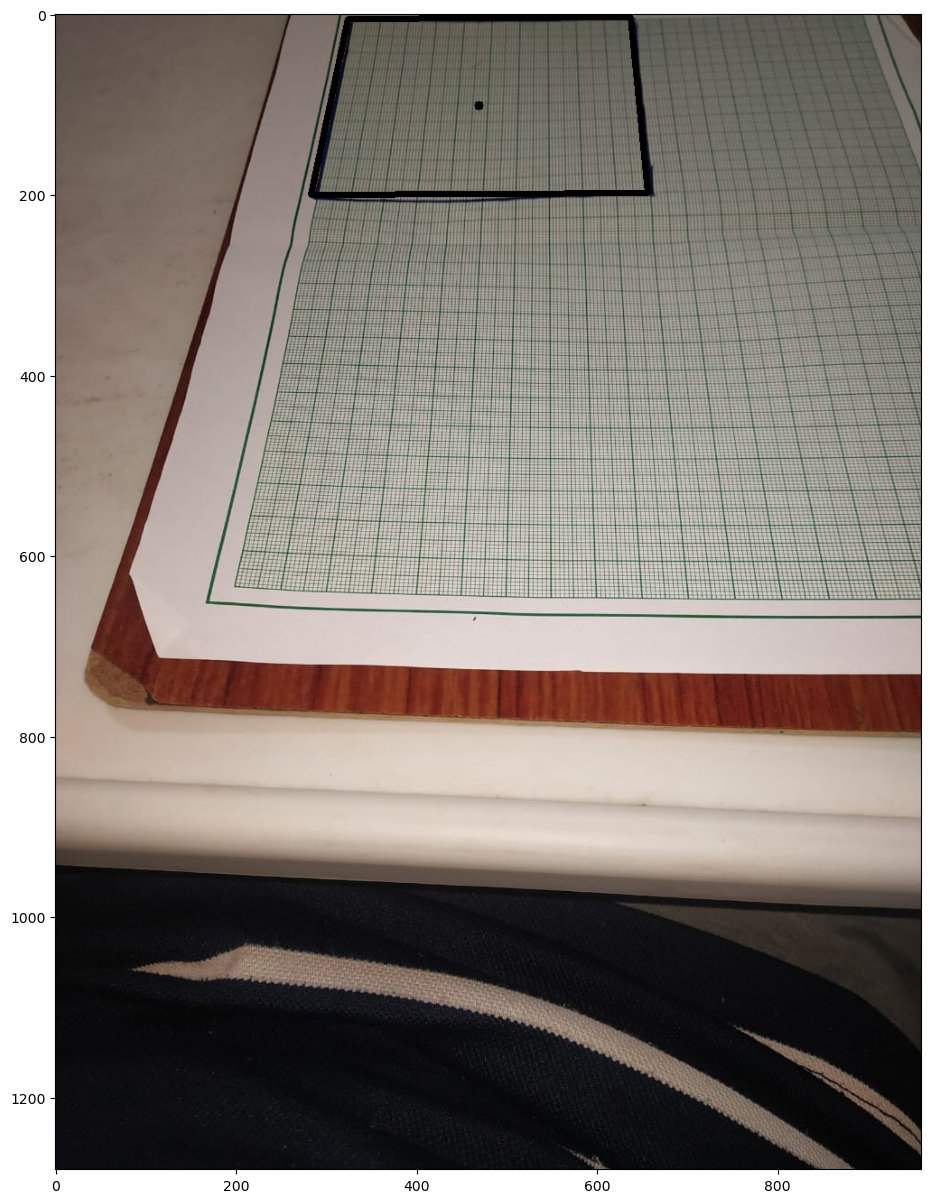

In [10]:
coord1min = min(quadrangle_vertices[:,0])
coord1max = max(quadrangle_vertices[:,0])
coord2min = min(quadrangle_vertices[:,1])
coord2max = max(quadrangle_vertices[:,1])
    
a = [coord1min, coord2min]
c = [coord1max, coord2min]
d = [coord1max, coord2max]
b = [coord1min, coord2max]
    
four_points = [a,c,d,b]
centre_x = 0.5*(coord1min + coord1max)
centre_y = 0.5*(coord2min + coord2max)
centre_xy = [int(centre_x), int(centre_y)]


color = (0, 0, 0) 
thickness_poly = 5
isClosed = True

# Radius of circle 
radius = 5   
# Blue color in BGR 
color = (0, 0, 0)    
# Line thickness of 2 px 
thickness_circle = -1

#to check whether the centre of the
#rectangle lies with in the quadrangle


img_lines_circle = imgrgb.copy()

img_lines_circle = cv2.polylines(img_lines_circle, [quadrangle_vertices], isClosed, color, thickness_poly) 

center_coordinates = tuple(centre_xy)
try:
    img_lines_circle = cv2.circle(img_lines_circle, center_coordinates, radius, color, thickness_circle) 
except:
    pass
    

imgD.plotImg(img_lines_circle)

### The following image shows the extent of warping (perspective transform) done by the Cam Scanner

/var/folders/fc/mjdjhyc14l1fg9j0fbzhj0_00000gn/T/ipykernel_28719/3416806670.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.scale = np.float(scale)
/var/folders/fc/mjdjhyc14l1fg9j0fbzhj0_00000gn/T/ipykernel_28719/3416806670.py:23: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  self.img_rs = transform.rescale(self.img,self.scale,multichannel=False)


Aspect ratio using Cam Scanner
1.5878378378378377


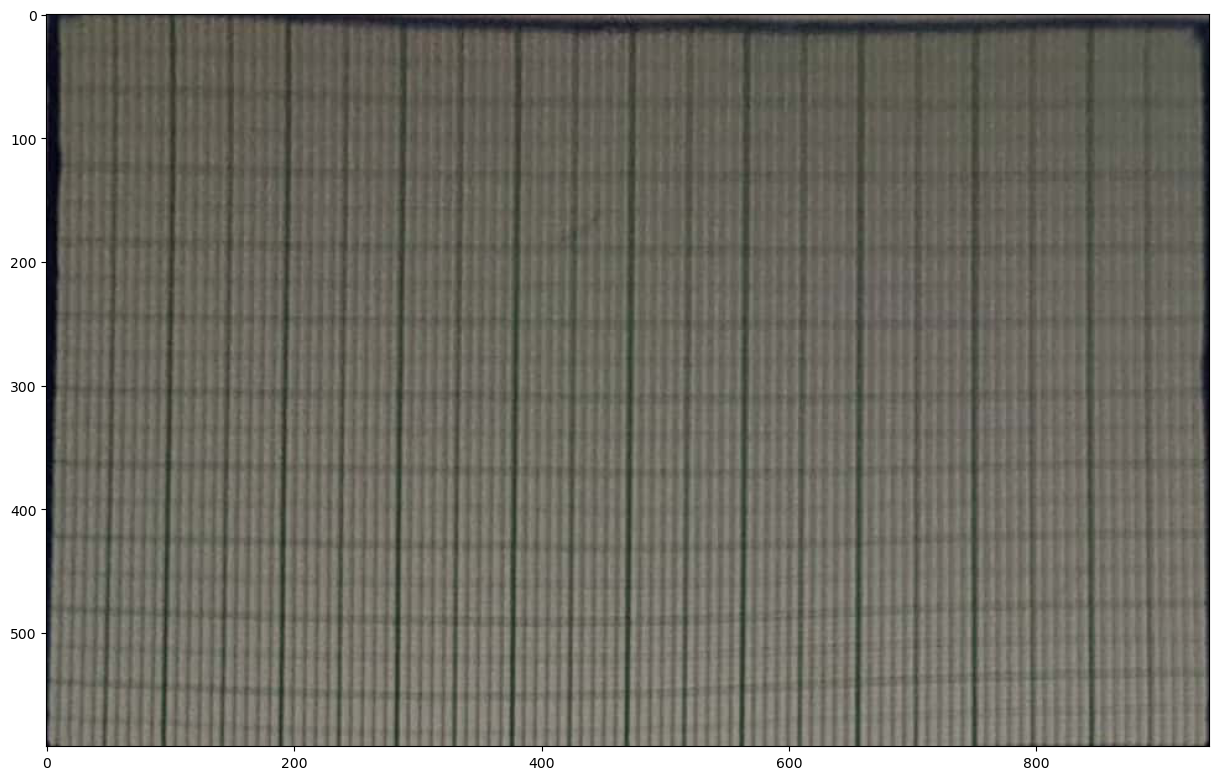

In [11]:
#img from camscanner

img_cs_file = '/Users/praneeth/Desktop/Image_Warping/Cam_Scanner/img05_cs.jpeg'

farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters

imgD = ImageDetection(img_cs_file,farmWidth)
img_cs = imgD.read(invert=False)
imgrgb_cs = imgD.readRGB()
scale = 1.0/4.0
img_rs_cs = imgD.rescale(img_cs,scale)

cs_temp = imgrgb_cs.shape[0]/imgrgb_cs.shape[1]
asp_ratio_cs = max(cs_temp, 1/cs_temp)

print('Aspect ratio using Cam Scanner')
print(asp_ratio_cs)

imgD.plotImg(imgrgb_cs)




### The following image shows the extent of warping (perspective transform) done by Algo 1 which is based on the procedure outlined in this research paper incorporating concepts from linear algebraic transformations in vector spaces


### Proc. IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP 2004), Montreal, Quebec, 17–21 May, 2004.

Aspect ratio using Algo 1
2.028582842749926


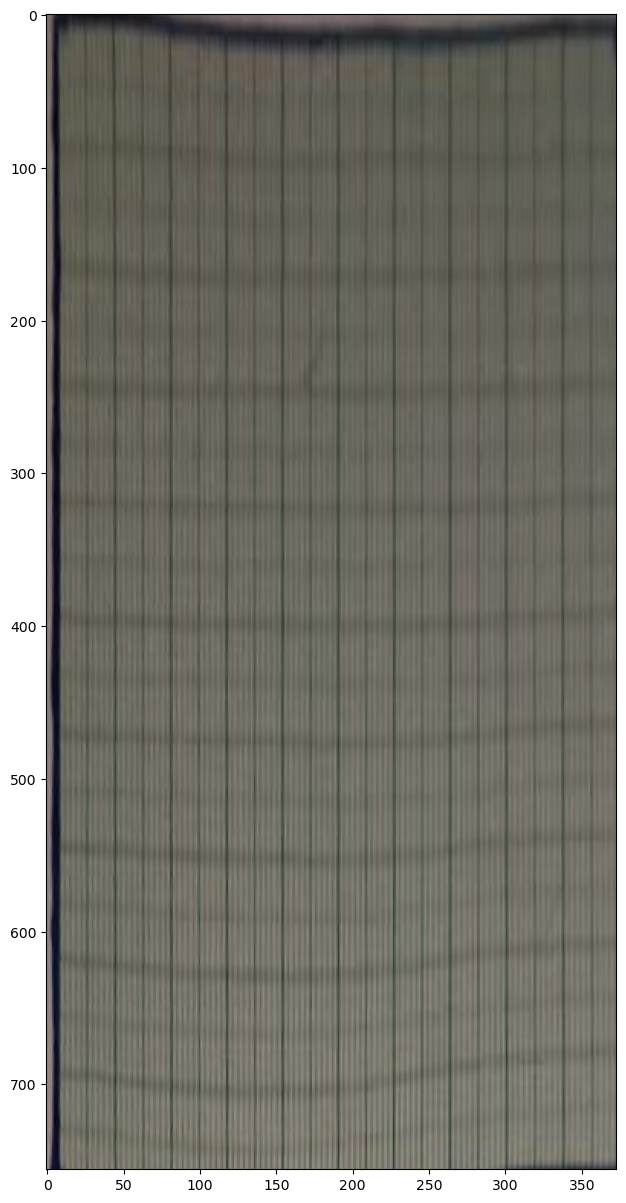

In [12]:
#warping using LINAL algo using sophisticated focal length & estimation of aspect ratio

ordered_points = order_points(quadrangle_vertices)
ordered_points_int = np.int32(ordered_points)
asp_ratio_algo1_temp = asp_ratio(imgrgb, ordered_points_int, center_coordinates)[0]
asp_ratio_algo1 = max(asp_ratio_algo1_temp, 1/asp_ratio_algo1_temp)
warped_img_algo1 = asp_ratio(imgrgb, ordered_points_int, center_coordinates)[1]



print('Aspect ratio using Algo 1')
print(asp_ratio_algo1)
imgD.plotImg(warped_img_algo1)

#Yet to be incorporated
#The printed values are the values of the focal length - focal length is not intended to be outputed by the algorithm
#but the focal length is computed automatically by the algorithm

### The following image shows the extent of warping (perspective transform) done by Algo 2 which is based on a simple rudimentary procedure in which there is no use of linear algebra techniques, but a common-sense approach of marking the extremities of the trapezium is used

Aspect ratio using Algo 2
1.8743718592964824


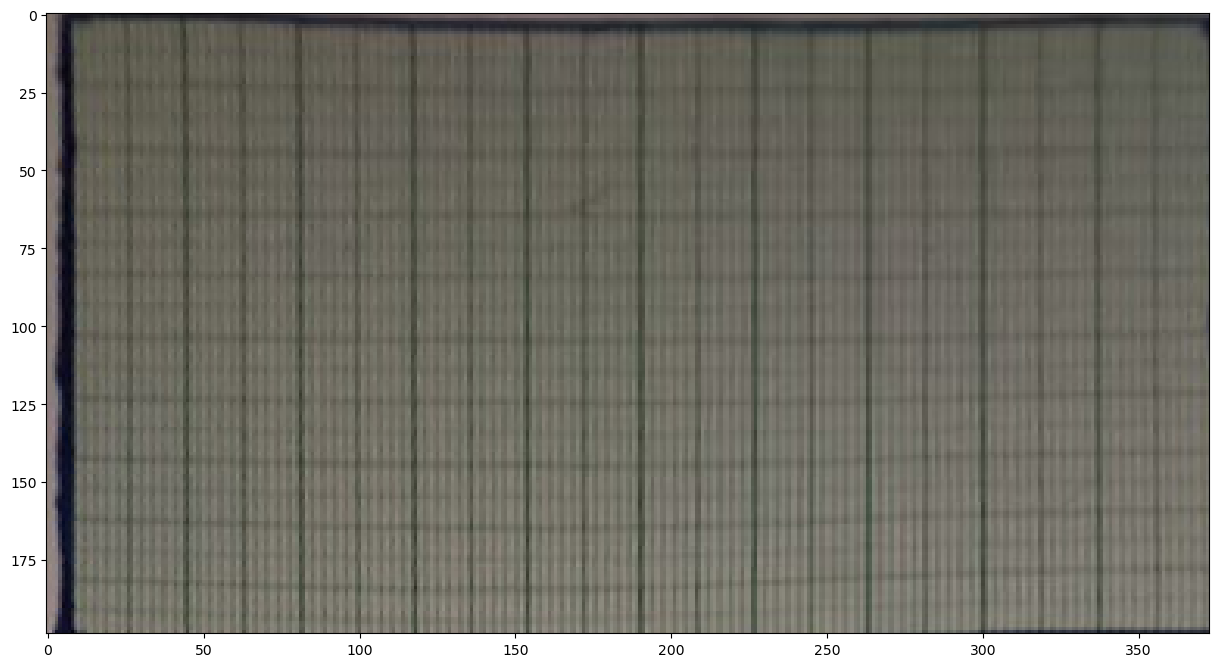

In [13]:
#warping using simple algo

ordered_points = order_points(quadrangle_vertices)
ordered_points_int = np.int32(ordered_points)
asp_ratio_algo2_temp = asp_ratio_simpler(imgrgb, ordered_points_int)[0]
asp_ratio_algo2 = max(asp_ratio_algo2_temp, 1/asp_ratio_algo2_temp)
warped_img_algo2 = asp_ratio_simpler(imgrgb, ordered_points_int)[1]


print('Aspect ratio using Algo 2')
print(asp_ratio_algo2)
imgD.plotImg(warped_img_algo2)





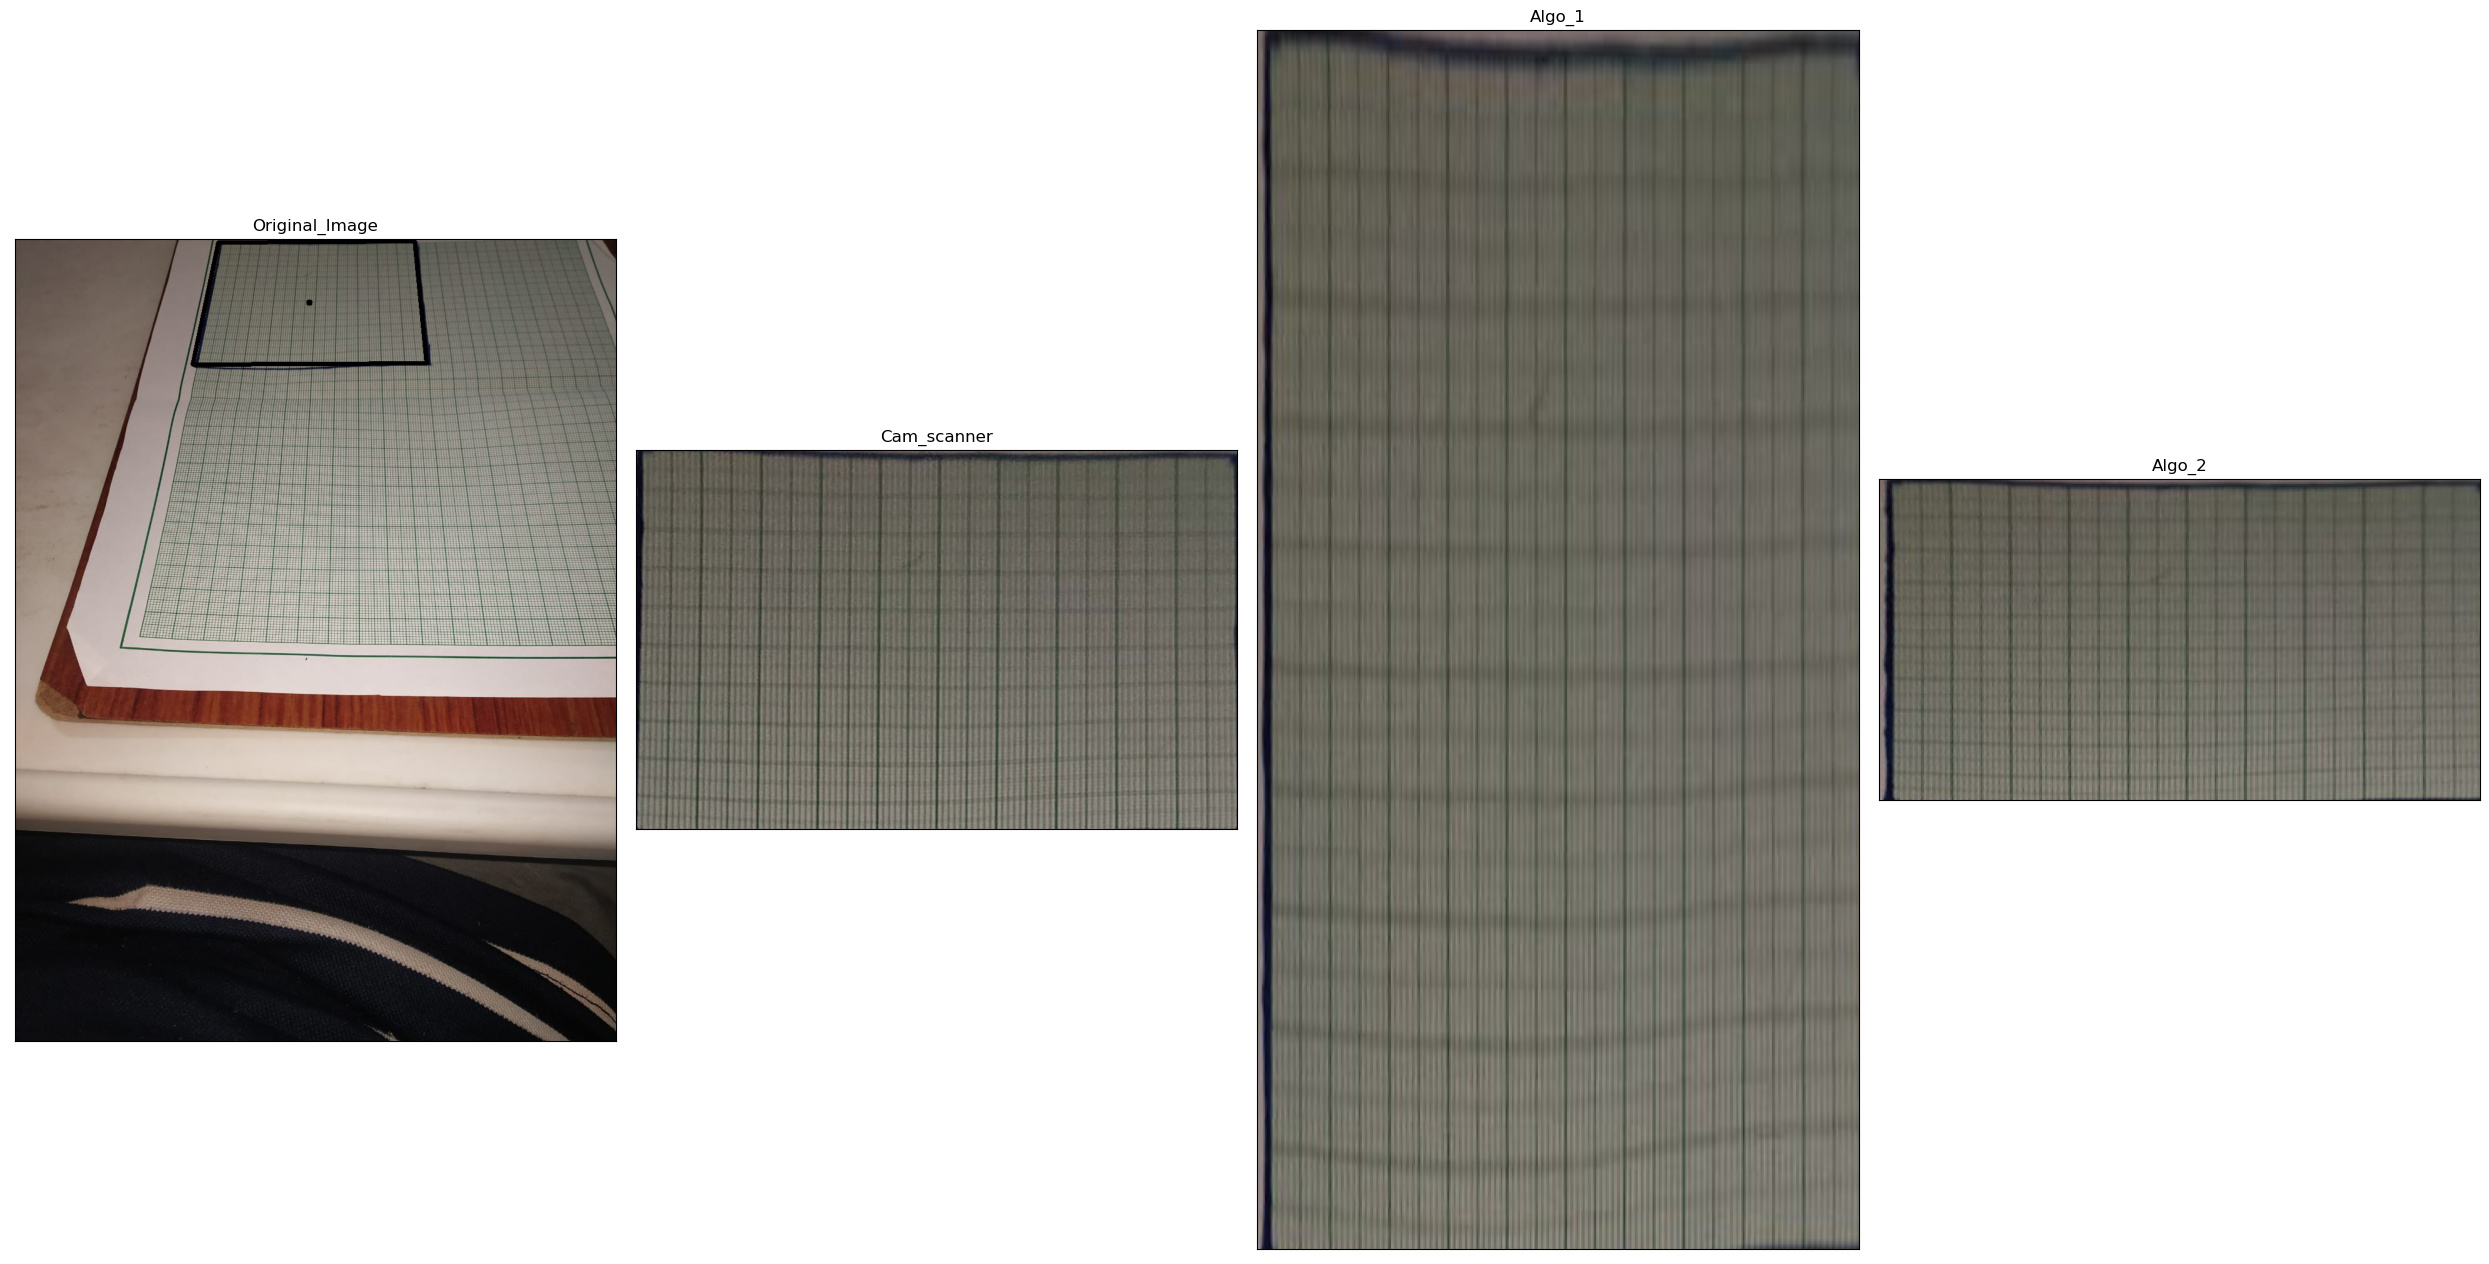

In [14]:

fig = plt.figure(figsize = (25,25))
   
ax0 = fig.add_subplot(1,4,1)
ax0.imshow(img_lines_circle)
ax0.set_title('Original_Image')

ax1 = fig.add_subplot(1,4,2)
ax1.imshow(imgrgb_cs)
ax1.set_title('Cam_scanner')


ax2 = fig.add_subplot(1,4,3)
ax2.imshow(warped_img_algo1)
ax2.set_title('Algo_1')

ax3 = fig.add_subplot(1,4,4)
ax3.imshow(warped_img_algo2)
ax3.set_title('Algo_2')



ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])




plt.tight_layout()
plt.show()

In [15]:
#Global variables
#Deriving a for loop of all the graphs

num_images = 21
asp_ratio_actual = np.ones(num_images)

In [16]:
q1 = np.array([[58,291], [863, 267], [894,1100],[65,1100]], np.int32)

q2 = np.array([[152, 281], [753, 262], [788,900], [133, 898]], np.int32)

q3 = np.array([[218, 36], [743, 25], [769, 533], [190, 535]], np.int32)

q4 = np.array([[292, 56], [629, 48], [657, 286], [247, 291]], np.int32)

q5 = np.array([[324,5], [637,3], [656,198], [283,200]], np.int32)

q6 = np.array([[228, 790], [395, 790], [391, 971], [216, 973]], np.int32)

q7 = np.array([[303, 276], [505, 281], [501, 469], [289,458]], np.int32)

q8 = np.array([[367, 28], [482, 28], [480,134], [364,136]], np.int32)

q9 = np.array([[201, 195 ], [1130, 181     ], [ 1130, 1080     ],[222,1090     ]], np.int32)
q10 = np.array([[120, 621    ], [747, 633      ], [ 730, 1290    ],[111,1265     ]], np.int32)
q11 = np.array([[112, 108    ], [756, 141      ], [ 738, 815     ],[46, 782     ]], np.int32)
q12 = np.array([[265, 261    ], [549, 274      ], [542, 564      ],[246, 541     ]], np.int32)

q13 = np.array([[209, 234    ], [453, 240      ], [457, 493      ],[209, 487     ]], np.int32)
q14 = np.array([[292, 361    ], [648, 377      ], [654, 760    ],[292, 737    ]], np.int32)
q15 = np.array([[444, 511    ], [970, 515      ], [975, 1020    ],[434, 1020 ]], np.int32)
q16 = np.array([[195, 212    ], [1220, 228     ], [1180, 1280   ],[120, 1240    ]], np.int32)

q17 = np.array([[696, 181   ], [ 1605, 194   ], [ 1590, 1100  ],[679, 1070   ]], np.int32)
q18 = np.array([[510, 139   ], [ 1380, 177   ], [ 1510, 1150  ],[548, 1040   ]], np.int32)
q19 = np.array([[586, 176   ], [ 1460, 163   ], [ 1590, 1080  ],[660, 1030   ]], np.int32)
q20 = np.array([[912, 1030   ], [1880, 1130    ], [1630, 2060   ],[749, 2050   ]], np.int32)
q21 = np.array([[612, 562   ], [1370, 504    ], [1260, 1300  ],[455, 1370   ]], np.int32)


q = [q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, q15, q16, q17, q18, q19, q20, q21]

In [17]:
#global variables

farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters

#Line variables (poly line enclosing)

color = (0, 0, 0) 
thickness_poly = 5
isClosed = True

#Circle variables
# Radius of circle 
radius = 5   
# Blue color in BGR 
color = (0, 0, 0)    
# Line thickness of 2 px 
thickness_circle = -1

In [18]:
base_dir = '/Users/praneeth/Desktop/Image_Warping/Original'
im_jpeg_locs = os.listdir(base_dir)
original_img_locs = [os.path.join(base_dir,im_jpeg_loc) for im_jpeg_loc in im_jpeg_locs]
cs_img_locs = [os.path.join(base_dir,im_jpeg_loc) for im_jpeg_loc in im_jpeg_locs]

In [19]:
#Global lists to which all will be appended

imgrgb_overall = []
img_lines_circle_overall = []
center_coordinates_overall = []


imgrgb_cs_overall = []
asp_ratio_cs_overall = []

ordered_points_int_overall = []

asp_ratio_algo1_overall = []
warped_img_algo1_overall = []

asp_ratio_algo2_overall = []
warped_img_algo2_overall = []



for i in range(num_images):

    #Original
    imgD1 = ImageDetection(original_img_locs[i],farmWidth)
    img = imgD1.read(invert=False)
    imgrgb = imgD1.readRGB()


    #Cam Scanner Image
    imgD2 = ImageDetection(cs_img_locs[i],farmWidth)
    img_cs = imgD2.read(invert=False)
    imgrgb_cs = imgD2.readRGB()

    cs_temp = imgrgb_cs.shape[0]/imgrgb_cs.shape[1]
    asp_ratio_cs = max(cs_temp, 1/cs_temp)



    #Quadrangle vertices & centre calculation
    quadrangle_vertices = q[i]

    coord1min = min(quadrangle_vertices[:,0])
    coord1max = max(quadrangle_vertices[:,0])
    coord2min = min(quadrangle_vertices[:,1])
    coord2max = max(quadrangle_vertices[:,1])

    a = [coord1min, coord2min]
    c = [coord1max, coord2min]
    d = [coord1max, coord2max]
    b = [coord1min, coord2max]

    four_points = [a,c,d,b]
    centre_x = 0.5*(coord1min + coord1max)
    centre_y = 0.5*(coord2min + coord2max)
    centre_xy = [int(centre_x), int(centre_y)]

    #Drawing img_lines_circle

    img_lines_circle = imgrgb.copy()

    img_lines_circle = cv2.polylines(img_lines_circle, [quadrangle_vertices], isClosed, color, thickness_poly) 

    center_coordinates = tuple(centre_xy)


    try:
        img_lines_circle = cv2.circle(img_lines_circle, center_coordinates, radius, color, thickness_circle) 
    except:
        pass


    ordered_points = order_points(quadrangle_vertices)
    ordered_points_int = np.int32(ordered_points)
    asp_ratio_algo1_temp = asp_ratio(imgrgb, ordered_points_int, center_coordinates)[0]
    asp_ratio_algo1 = max(asp_ratio_algo1_temp, 1/asp_ratio_algo1_temp)
    warped_img_algo1 = asp_ratio(imgrgb, ordered_points_int, center_coordinates)[1]

    asp_ratio_algo2_temp = asp_ratio_simpler(imgrgb, ordered_points_int)[0]
    asp_ratio_algo2 = max(asp_ratio_algo2_temp, 1/asp_ratio_algo2_temp)
    warped_img_algo2 = asp_ratio_simpler(imgrgb, ordered_points_int)[1]


    imgrgb_overall.append(imgrgb)
    img_lines_circle_overall.append(img_lines_circle)
    center_coordinates_overall.append(center_coordinates)

    imgrgb_cs_overall.append(imgrgb_cs)
    asp_ratio_cs_overall.append(asp_ratio_cs)

    ordered_points_int_overall.append(ordered_points_int)

    asp_ratio_algo1_overall.append(asp_ratio_algo1)
    warped_img_algo1_overall.append(warped_img_algo1)

    asp_ratio_algo2_overall.append(asp_ratio_algo2)
    warped_img_algo2_overall.append(warped_img_algo2)


In [26]:
import pandas as pd

data_tuples = list(zip(asp_ratio_actual,asp_ratio_cs_overall, asp_ratio_algo1_overall, asp_ratio_algo2_overall ))

aspect_ratio = pd.DataFrame(data_tuples, columns=['Original Aspect Ratio','Cam Scanner AR', 'Algo 1 AR', 'Algo 2 AR'])  

#percentage deviation from 1

algocs_deviation = np.round(((asp_ratio_cs_overall - asp_ratio_actual)*100/asp_ratio_actual),2)
algo1_deviation = np.round(((asp_ratio_algo1_overall - asp_ratio_actual)*100/asp_ratio_actual),2)
algo2_deviation = np.round(((asp_ratio_algo2_overall - asp_ratio_actual)*100/asp_ratio_actual),2)


deviations_tuples = list(zip(algocs_deviation,algo1_deviation, algo2_deviation))

deviations_dataframe = pd.DataFrame(deviations_tuples, columns=['Cam Scanner % deviation','Algo 1 % deviation', 'Algo 2 % deviation'])  


In [27]:
aspect_ratio

Original Aspect Ratio  Cam Scanner AR  Algo 1 AR  Algo 2 AR
0                     1.0        1.333333   1.004296   1.004825
1                     1.0        1.333333   1.002033   1.026646
2                     1.0        1.132275   1.052563   1.139764
3                     1.0        1.980456   1.108614   1.715481
4                     1.0        1.333333   2.028583   1.874372
5                     1.0        1.757895   1.161662   1.045714
6                     1.0        1.258206   1.109334   1.127660
7                     1.0        1.182310   1.106345   1.074074
8                     1.0        1.295620   1.020522   1.033370
9                     1.0        1.334783   1.037980   1.047847
10                    1.0        1.333333   1.144836   1.022157
11                    1.0        1.464706   1.012879   1.020690
12                    1.0        2.736842   1.567798   1.020161
13                    1.0        1.361702   1.048507   1.058011
14                    1.0        1.263581   1.050133   1.062868
15                    1.0        1.333333   1.012543   1.007605
16                    1.0        1.031509   1.035306   1.005519
17                    1.0        1.309353   1.067508   1.013430
18                    1.0        1.333333   1.042990   1.005400
19                    1.0        1.333333   1.111616   1.060637
20                    1.0        1.333333   1.551933   1.018564

### One can observe in the following graph that the aspect ratio deviations from 1.00 are least in the Cam Scanner, while Algo 1 and Algo 2 result in high deviations. However, the Algo 1 aspect ratio tends to deviate from 1.00 by a very high percentage for certain photographs

In [28]:
deviations_dataframe.sort_values(by = 'Cam Scanner % deviation', ascending= False)

Cam Scanner % deviation  Algo 1 % deviation  Algo 2 % deviation
12                   173.68               56.78                2.02
3                     98.05               10.86               71.55
5                     75.79               16.17                4.57
11                    46.47                1.29                2.07
13                    36.17                4.85                5.80
9                     33.48                3.80                4.78
0                     33.33                0.43                0.48
19                    33.33               11.16                6.06
18                    33.33                4.30                0.54
15                    33.33                1.25                0.76
10                    33.33               14.48                2.22
1                     33.33                0.20                2.66
4                     33.33              102.86               87.44
20                    33.33               55.19                1.86
17                    30.94                6.75                1.34
8                     29.56                2.05                3.34
14                    26.36                5.01                6.29
6                     25.82               10.93               12.77
7                     18.23               10.63                7.41
2                     13.23                5.26               13.98
16                     3.15                3.53                0.55

In [29]:
deviations_dataframe.loc[:,['Algo 2 % deviation','Cam Scanner % deviation'] ].sort_values(by = 'Algo 2 % deviation', ascending= False)

Algo 2 % deviation  Cam Scanner % deviation
4                87.44                    33.33
3                71.55                    98.05
2                13.98                    13.23
6                12.77                    25.82
7                 7.41                    18.23
14                6.29                    26.36
19                6.06                    33.33
13                5.80                    36.17
9                 4.78                    33.48
5                 4.57                    75.79
8                 3.34                    29.56
1                 2.66                    33.33
10                2.22                    33.33
11                2.07                    46.47
12                2.02                   173.68
20                1.86                    33.33
17                1.34                    30.94
15                0.76                    33.33
16                0.55                     3.15
18                0.54                    33.33
0                 0.48                    33.33

#### In order to understand the high degrees of deviations from 1.00 observed for Algo 1, it was speculated that errors in the identification of the four corners of the quadrangle might have an impact in blowing up the deviations from 1.00. So in order to simulate the incorrect annotation, for the same image, the four corners of the quadrangle were annotated (around a radius of 5 pixels about the actual corner). This procedure was repeated for all the 20 photographs of the graph sheets, which resulted in an estimate for the maximum variability of the aspect ratio from 1.00 as observed in the following graph